/tmp/ipykernel_6434/156740593.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['DATE OF OCCURRENCE'] = pd.to_datetime(data['DATE OF OCCURRENCE'], errors='coerce')


                                                                                        CASE#  \
JG406115 08/31/2023 07:00:00 PM 042XX W MARQUETTE RD                498               BATTERY   
JG425966 09/15/2023 11:20:00 PM 010XX W 84TH ST                     486               BATTERY   
JG412467 08/31/2023 09:13:00 PM 093XX S WABASH AVE                  910   MOTOR VEHICLE THEFT   
JG426285 09/15/2023 06:00:00 PM 057XX S DR MARTIN LUTHER KING JR DR 1320      CRIMINAL DAMAGE   
JH178504 3/07/24 1:50           059XX W FULTON ST                   486               BATTERY   

                                                                         DATE OF OCCURRENCE  \
JG406115 08/31/2023 07:00:00 PM 042XX W MARQUETTE RD                498                 NaT   
JG425966 09/15/2023 11:20:00 PM 010XX W 84TH ST                     486                 NaT   
JG412467 08/31/2023 09:13:00 PM 093XX S WABASH AVE                  910                 NaT   
JG426285 09/15/2023 06:00:00 PM 057XX

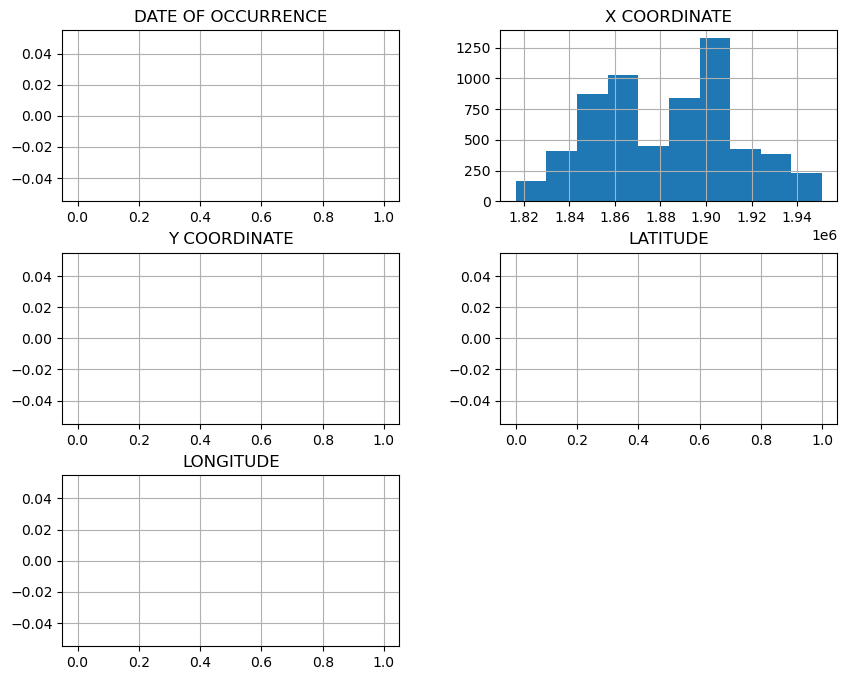

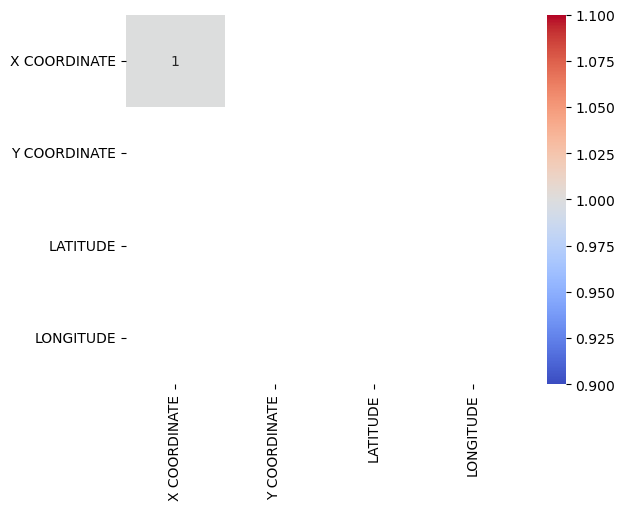

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
data = pd.read_csv('data.csv',low_memory=False)

# Limpiar los nombres de las columnas de espacios adicionales
data.columns = data.columns.str.strip()

# Convertir columnas numéricas y fechas
data['X COORDINATE'] = pd.to_numeric(data['X COORDINATE'], errors='coerce')
data['Y COORDINATE'] = pd.to_numeric(data['Y COORDINATE'], errors='coerce')
data['LATITUDE'] = pd.to_numeric(data['LATITUDE'], errors='coerce')
data['LONGITUDE'] = pd.to_numeric(data['LONGITUDE'], errors='coerce')
data['DATE OF OCCURRENCE'] = pd.to_datetime(data['DATE OF OCCURRENCE'], errors='coerce')

# Mostrar las primeras filas de los datos
print(data.head())

# Descripción estadística de los datos numéricos
print(data.describe())

# Distribución de características categóricas
categorical_columns = ['PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION', 'LOCATION DESCRIPTION']
for col in categorical_columns:
    print(f"Distribución de {col}:")
    print(data[col].value_counts())
    
# Histograma de las características numéricas
data.hist(figsize=(10, 8))
plt.show()

    # Mapa de calor de la correlación, solo para columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Limpiar espacios en los valores de las columnas categóricas
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].str.strip()

# Imputar valores nulos en columnas numéricas
numerical_cols = ['X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE']
for col in numerical_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col].fillna(data[col].mean(), inplace=True)

# Imputar valores en columnas categóricas y convertir a numéricas
categorical_cols = ['PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION', 'LOCATION DESCRIPTION', 
                    'IUCR', 'ARREST', 'DOMESTIC', 'BEAT', 'WARD', 'FBI CD']
for col in categorical_cols:
    if col in data.columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

# Eliminar columnas irrelevantes, ignorando errores si alguna no está presente
data = data.drop(columns=['CASE#', 'DATE OF OCCURRENCE', 'BLOCK', 'LOCATION'], errors='ignore')

# Verificar columnas con valores constantes o NaN
constant_columns = [col for col in data.columns if data[col].nunique() <= 1]
nan_columns = data.columns[data.isna().any()].tolist()
print("Columnas constantes:", constant_columns)
print("Columnas con valores NaN:", nan_columns)

# Eliminar columnas constantes y NaN si las hay
data = data.drop(columns=constant_columns + nan_columns, errors='ignore')

# Separar las características y el objetivo
X = data.drop(columns=['ARREST', 'DOMESTIC'])
y_arrest = data['ARREST']
y_domestic = data['DOMESTIC']

# Escalar características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_arrest_train, y_arrest_test = train_test_split(
    X_scaled, y_arrest, test_size=0.2, random_state=42
)
X_train, X_test, y_domestic_train, y_domestic_test = train_test_split(
    X_scaled, y_domestic, test_size=0.2, random_state=42
)


Columnas constantes: ['Y COORDINATE', 'LATITUDE', 'LONGITUDE']
Columnas con valores NaN: ['Y COORDINATE', 'LATITUDE', 'LONGITUDE']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Entrenar un modelo de clasificación de Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_arrest_train)

# Predecir en el conjunto de prueba
y_pred = clf.predict(X_test)

# Informar de clasificación
print(classification_report(y_arrest_test, y_pred))


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Crear una copia del DataFrame original y limpiar datos
data_cleaned = data.copy()

# Limpiar espacios en los valores de las columnas categóricas
for col in data_cleaned.select_dtypes(include='object').columns:
    data_cleaned[col] = data_cleaned[col].str.strip()

# Eliminar columnas irrelevantes que no son necesarias
data_cleaned = data_cleaned.drop(columns=['CASE#', 'DATE OF OCCURRENCE', 'BLOCK', 'LOCATION'], errors='ignore')

# Convertir las columnas numéricas y rellenar valores nulos con la media de cada columna
numerical_cols = ['X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE']
for col in numerical_cols:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')
    data_cleaned[col].fillna(data_cleaned[col].mean(), inplace=True)

# Imputar valores en columnas categóricas con el modo y convertirlas a numéricas con LabelEncoder
categorical_cols = ['PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION', 'LOCATION DESCRIPTION', 
                    'IUCR', 'ARREST', 'DOMESTIC', 'BEAT', 'WARD', 'FBI CD']
for col in categorical_cols:
    if col in data_cleaned.columns:
        data_cleaned[col].fillna(data_cleaned[col].mode()[0], inplace=True)
        le = LabelEncoder()
        data_cleaned[col] = le.fit_transform(data_cleaned[col])

# Verificar si persisten valores NaN después de la imputación y eliminarlos si los hay
data_cleaned.dropna(inplace=True)

# Separar características y objetivo, eliminando 'LATITUDE' y 'LONGITUDE' del conjunto de características
X = data_cleaned.drop(columns=['ARREST', 'DOMESTIC', 'LATITUDE', 'LONGITUDE'], errors='ignore')
y_latitude = data_cleaned['LATITUDE']
y_longitude = data_cleaned['LONGITUDE']

# Escalar características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos para latitud
X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(
    X_scaled, y_latitude, test_size=0.2, random_state=42
)

# Dividir los datos para longitud
X_train_long, X_test_long, y_train_long, y_test_long = train_test_split(
    X_scaled, y_longitude, test_size=0.2, random_state=42
)

# Crear y entrenar los modelos de Random Forest para latitud y longitud
reg_latitude = RandomForestRegressor(random_state=42)
reg_longitude = RandomForestRegressor(random_state=42)

# Entrenar los modelos
reg_latitude.fit(X_train_lat, y_train_lat)
reg_longitude.fit(X_train_long, y_train_long)

# Predicción y evaluación para latitud
y_pred_lat = reg_latitude.predict(X_test_lat)
print("MAE Latitud:", mean_absolute_error(y_test_lat, y_pred_lat))
print("MSE Latitud:", mean_squared_error(y_test_lat, y_pred_lat))

# Predicción y evaluación para longitud
y_pred_long = reg_longitude.predict(X_test_long)
print("MAE Longitud:", mean_absolute_error(y_test_long, y_pred_long))
print("MSE Longitud:", mean_squared_error(y_test_long, y_pred_long))


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by StandardScaler.

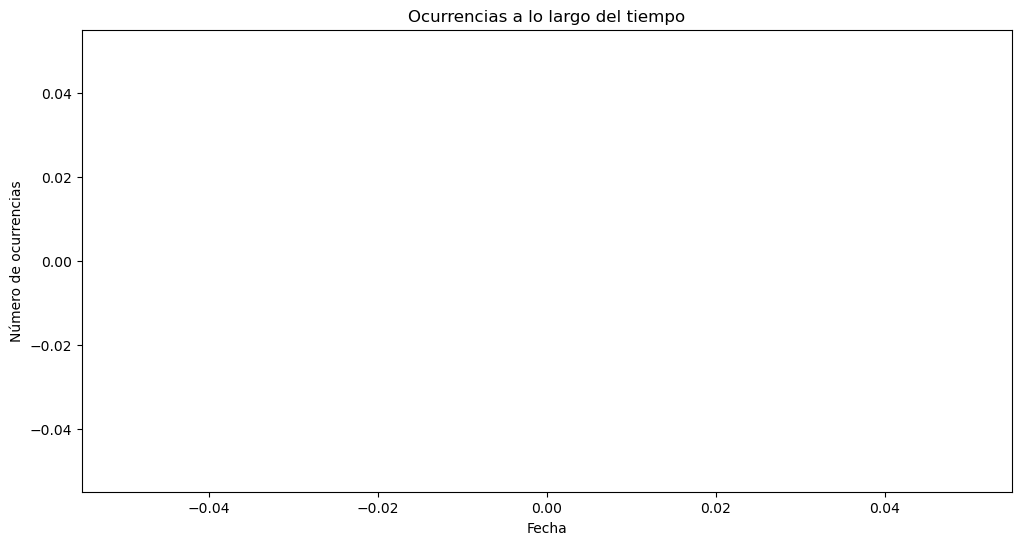

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarte de que la columna `DATE OF OCCURRENCE` esté en el DataFrame original para el análisis temporal
data_time_series = data.copy()  # Crear copia para la visualización de series temporales
data_time_series['DATE OF OCCURRENCE'] = pd.to_datetime(data_time_series['DATE OF OCCURRENCE'], errors='coerce')

# Filtrar filas nulas en `DATE OF OCCURRENCE`
data_time_series.dropna(subset=['DATE OF OCCURRENCE'], inplace=True)

# Agrupar datos por fecha y contar ocurrencias
time_series = data_time_series.groupby(data_time_series['DATE OF OCCURRENCE'].dt.date).size()

# Graficar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title("Ocurrencias a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Número de ocurrencias")
plt.show()


In [20]:
import folium
import pandas as pd

# Filtrar filas con coordenadas válidas
data_geo = data.dropna(subset=['LATITUDE', 'LONGITUDE']).copy()

# Asignar centro del mapa
if not data_geo.empty:
    center_lat = data_geo['LATITUDE'].mean()
    center_long = data_geo['LONGITUDE'].mean()
else:
    # Coordenadas de ejemplo si no hay datos válidos
    center_lat, center_long = 0, 0  # Usa coordenadas predeterminadas si no hay datos

# Crear el mapa con el centro definido
m = folium.Map(location=[center_lat, center_long], zoom_start=10)

# Añadir puntos al mapa si hay datos
if not data_geo.empty:
    for _, row in data_geo.iterrows():
        folium.Marker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            popup=row['PRIMARY DESCRIPTION']  # Personalizar popup con cualquier columna
        ).add_to(m)

# Mostrar el mapa interactivo
m


In [21]:
from sklearn.ensemble import IsolationForest

# Entrenar un modelo de Isolation Forest
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train)

# Predecir anomalías en el conjunto de prueba
y_pred_anomaly = iso_forest.predict(X_test)

# Contar el número de anomalías (los valores predichos como -1 se consideran anomalías)
num_anomalies = sum(y_pred_anomaly == -1)
print(f"Número de anomalías: {num_anomalies}")


Número de anomalías: 32993


In [25]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

# Definir las columnas categóricas
categorical_columns = ['PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION', 'LOCATION DESCRIPTION']

# Filtrar los datos categóricos y manejar valores nulos
data_categorical = data[categorical_columns].fillna('Unknown')  # Llenar NaNs con 'Unknown'

# Convertir los datos categóricos a formato one-hot encoding
data_categorical_one_hot = pd.get_dummies(data_categorical)

# Aplicar el algoritmo de Apriori
frequent_itemsets = apriori(data_categorical_one_hot, min_support=0.05, use_colnames=True)

# Revisar el resultado del algoritmo Apriori antes de proceder
print(frequent_itemsets.head())

# Extraer reglas de asociación
try:
    rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)
    print(rules)
except TypeError as e:
    print(f"Error al extraer reglas de asociación: {e}")


    support                 itemsets
0  0.809896  (PRIMARY DESCRIPTION_N)
1  0.175419  (PRIMARY DESCRIPTION_Y)
Error al extraer reglas de asociación: association_rules() missing 1 required positional argument: 'num_itemsets'


In [4]:
import shap
import warnings
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Entrenar el modelo (usando Random Forest como ejemplo)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_arrest_train)

# Calcular valores SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Visualizar la importancia de las características
shap.summary_plot(shap_values[1], X_test, plot_type='bar')


NameError: name 'X_train' is not defined

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generar datos de ejemplo
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_domestic_train, y_domestic_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Convertir los datos a tensores
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_domestic_train_torch = torch.tensor(y_domestic_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_domestic_test_torch = torch.tensor(y_domestic_test, dtype=torch.float32)

# Crear la red y definir la función de pérdida y el optimizador
net = Net()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Entrenar la red neuronal
num_epochs = 100
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_domestic_train_torch.view(-1, 1))
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Evaluar la red neuronal
net.eval()
with torch.no_grad():
    outputs_test = net(X_test_torch)
    outputs_test = outputs_test.view(-1).round()
    accuracy = (outputs_test == y_domestic_test_torch).float().mean()
    print(f"Accuracy: {accuracy.item()}")


Epoch 1, Loss: 0.7043581604957581
Epoch 11, Loss: 0.6591484546661377
Epoch 21, Loss: 0.6185668110847473
Epoch 31, Loss: 0.580149233341217
Epoch 41, Loss: 0.5424115657806396
Epoch 51, Loss: 0.5050119161605835
Epoch 61, Loss: 0.4684330224990845
Epoch 71, Loss: 0.43334633111953735
Epoch 81, Loss: 0.40077438950538635
Epoch 91, Loss: 0.37148961424827576
Accuracy: 0.824999988079071


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Generar datos de ejemplo
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_arrest_train, y_arrest_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelos de clasificación
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Entrenar y evaluar los modelos
for model_name, model in models.items():
    model.fit(X_train, y_arrest_train)
    y_pred = model.predict(X_test)
    print(f"--- {model_name} ---")
    print(classification_report(y_arrest_test, y_pred))


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       145
           1       0.89      0.83      0.86       155

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

--- SVM ---
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       145
           1       0.86      0.81      0.83       155

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       145
           1       0.88      0.83      0.85       155

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


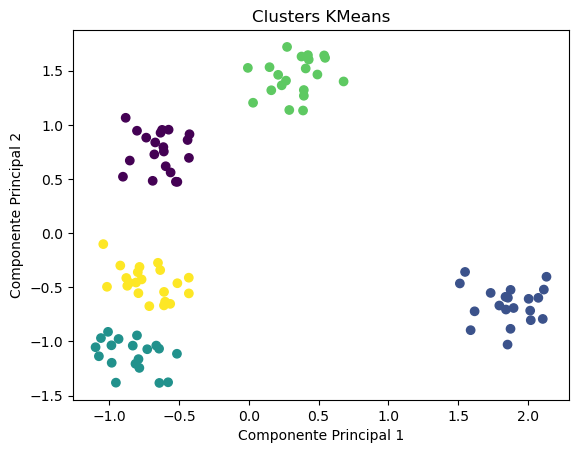

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Crear un conjunto de datos de ejemplo
X, _ = make_blobs(n_samples=100, centers=5, cluster_std=1.0, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering con KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualizar los clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters KMeans')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()


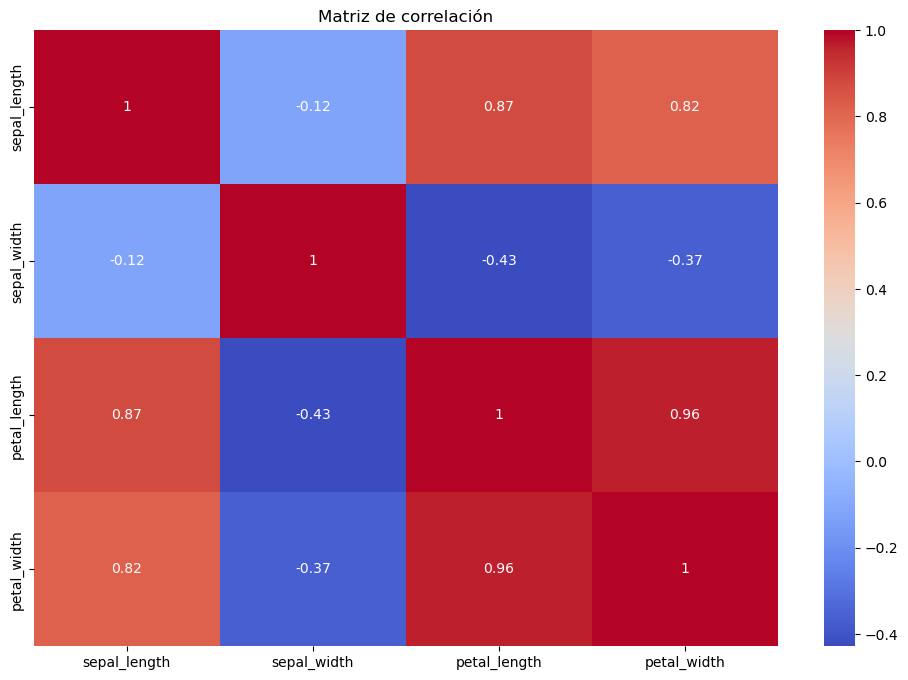

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el conjunto de datos 'iris'
data = sns.load_dataset('iris')

# Seleccionar solo las columnas numéricas
data_numeric = data.select_dtypes(include=['float64', 'int64'])

# Calcular matriz de correlación
corr_matrix = data_numeric.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()


In [15]:
from imblearn.over_sampling import SMOTE
# Manejar el desequilibrio de datos en 'ARREST'
smote = SMOTE(random_state=42)
X_resampled, y_arrest_resampled = smote.fit_resample(X_train, y_arrest_train)
# Entrenar un modelo de clasificación de Random Forest con datos reequilibrados
clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_arrest_resampled)
# Evaluar el modelo
y_pred = clf.predict(X_test)
print(classification_report(y_arrest_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       145
           1       0.89      0.83      0.86       155

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Entrenar un modelo de árbol de decisión
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_arrest_train)

# Entrenar un modelo de bosque aleatorio
rforest = RandomForestClassifier(random_state=42)
rforest.fit(X_train, y_arrest_train)

# Evaluar el árbol de decisión
y_pred_tree = dtree.predict(X_test)
print("Clasificación con Árbol de Decisión:")
print(classification_report(y_arrest_test, y_pred_tree))

# Evaluar el bosque aleatorio
y_pred_forest = rforest.predict(X_test)
print("Clasificación con Bosque Aleatorio:")
print(classification_report(y_arrest_test, y_pred_forest))


Clasificación con Árbol de Decisión:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       145
           1       0.86      0.86      0.86       155

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

Clasificación con Bosque Aleatorio:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       145
           1       0.89      0.83      0.86       155

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Vectorizar las descripciones
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(data['PRIMARY DESCRIPTION'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_text_train, X_text_test, y_arrest_train, y_arrest_test = train_test_split(
    X_text, y_arrest, test_size=0.2, random_state=42
)

# Entrenar un modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_text_train, y_arrest_train)

# Evaluar el modelo
y_pred = nb_model.predict(X_text_test)
print(classification_report(y_arrest_test, y_pred))


KeyError: 'PRIMARY DESCRIPTION'

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Visualizar los datos reducidos
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['ARREST'].apply(lambda x: 0 if x == 'N' else 1),
cmap='coolwarm')
plt.title('Reducción de dimensionalidad con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

KeyError: 'ARREST'

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Visualizar los datos reducidos
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['ARREST'].apply(lambda x: 0 if x == 'N' else 1),
cmap='coolwarm')
plt.title('Reducción de dimensionalidad con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

KeyError: 'ARREST'

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Definir el modelo
clf = RandomForestClassifier(random_state=42)
# Definir los hiperparámetros a optimizar
param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [None, 10, 20, 30],
'min_samples_split': [2, 5, 10]
}
# Optimización de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_arrest_train)
# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)
# Evaluar el modelo con los mejores hiperparámetros
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_arrest_test, y_pred))

Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       145
           1       0.89      0.83      0.86       155

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



In [1]:
from fbprophet import Prophet
import pandas as pd
# Preprocesar los datos para Prophet
data['ds'] = data['DATE OF OCCURRENCE']
data['y'] = data.groupby(data['DATE OF OCCURRENCE'].dt.date).size().values
# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(data)
# Hacer pronósticos futuros
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
# Visualizar el pronóstico
fig = model.plot(forecast)
plt.show()

ModuleNotFoundError: No module named 'fbprophet'

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Cargar los datos
data = pd.read_csv('data.csv', low_memory=False)  # Ajuste para advertencias de tipo

# Convertir todas las columnas categóricas (texto) a strings para evitar errores
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype(str)

# Identificar y transformar todas las columnas categóricas
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Asegurarse de que las columnas numéricas estén en el formato correcto
numeric_cols = ['IUCR', 'BEAT', 'WARD', 'FBI CD', 'X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Rellenar los valores faltantes en las columnas numéricas con la media
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Escalar las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop(['ARREST'], axis=1))

# Separar variables independientes y dependientes
X = X_scaled
y = data['ARREST'].apply(lambda x: 1 if x == 'Y' else 0)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Guardar el modelo y otros recursos
joblib.dump(model, 'model_arrest.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']

In [8]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib

app = Flask(__name__)

# Cargar el modelo entrenado y otros recursos
model = joblib.load('model_arrest.pkl')
scaler = joblib.load('scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    # Obtener los datos de entrada en formato JSON
    data = request.get_json()

    # Convertir a DataFrame
    df = pd.DataFrame([data])

    # Preprocesar los datos
    df = preprocess_data(df)

    # Hacer predicción
    prediction = model.predict(df)
    
    # Convertir predicción a un formato legible
    prediction_label = 'Y' if prediction[0] == 1 else 'N'

    # Devolver la predicción como JSON
    return jsonify({'prediction': prediction_label})

def preprocess_data(df):
    # Convertir características categóricas a numéricas
    for col, le in label_encoders.items():
        if col in df.columns:
            df[col] = le.transform(df[col].fillna(''))

    # Escalar características numéricas
    df_scaled = scaler.transform(df)
    return df_scaled

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/conda/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.11/site-packages/traitlets/config/application.py", line 1052, in launch_instance
    app.initialize(argv)
  File "/opt/conda/lib/python3.11/site-packages/traitlets/config/application.py", line 117, in inner
    return method(app, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.1

SystemExit: 1

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
